# load, process, and grid ERDDAP 

An attempt make the real-time glider data easier to work with. 

This is a little fast and loose, so caveat emptor for sciecne!

In [24]:
import xarray as xr
import pandas as pd
from erddapy import ERDDAP
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

import numpy as np

from scipy.signal import find_peaks

from scipy import stats

In [3]:
# this creates a link to the RUCOOL server:
e = ERDDAP(
    server="http://slocum-data.marine.rutgers.edu/erddap",
    protocol="tabledap",
    response="nc",
)

# get the science data:
e.dataset_id = 'ru29-20200908T1623-profile-sci-rt'

# this connects to the data and load into an xarray
# ds = e.to_xarray()
ds = e.to_pandas()
# remove the spaces from the columns
ds.columns = ds.columns.str.split(' ').str[0]



# get the time to be a datetime object
ds['time'] = pd.to_datetime(ds['time'])
ds = ds.sort_values(by=['time'])

print(ds.info())
ds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472171 entries, 0 to 472170
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   time                           472171 non-null  object 
 1   latitude                       472171 non-null  float64
 2   longitude                      472171 non-null  float64
 3   depth                          273181 non-null  float64
 4   trajectory                     472171 non-null  object 
 5   source_file                    472171 non-null  object 
 6   beta_700nm                     134175 non-null  float64
 7   cdom                           134177 non-null  float64
 8   chlorophyll_a                  134177 non-null  float64
 9   conductivity                   273155 non-null  float64
 10  crs                            0 non-null       float64
 11  ctd41cp_timestamp              273055 non-null  object 
 12  density                       

,time,latitude,longitude,depth,trajectory,source_file,beta_700nm,cdom,chlorophyll_a,conductivity,...,sci_ad2cp_run_state,sci_ad2cp_surface_state,sci_m_disk_free,sci_m_present_time,sci_water_pressure,sound_speed,temperature,u,v,water_depth
0,2020-09-08T16:28:35Z,18.177151,-64.805848,6.291905,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000110,0.7208,0.0648,5.78587,...,5.0,0.0,NaN,2020-09-08T16:28:35Z,0.633,1544.6094,29.6361,NaN,NaN,NaN
1,2020-09-08T16:28:47Z,18.177142,-64.805823,8.319587,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000110,0.8109,0.0864,5.78270,...,NaN,NaN,NaN,2020-09-08T16:28:47Z,0.837,1544.5654,29.5950,NaN,NaN,NaN
2,2020-09-08T16:28:59Z,18.177132,-64.805798,10.963495,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000139,1.1713,0.1008,5.78063,...,NaN,NaN,NaN,2020-09-08T16:28:59Z,1.103,1544.5435,29.5569,NaN,NaN,NaN
3,2020-09-08T16:29:12Z,18.177123,-64.805773,13.557673,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000115,0.7208,0.0936,5.78405,...,NaN,NaN,NaN,2020-09-08T16:29:12Z,1.364,1544.5581,29.5177,NaN,NaN,NaN
4,2020-09-08T16:29:24Z,18.177113,-64.805748,16.181635,ru29-20200908T1623,ru29-2020-251-4-0-sbd(04270000),0.000112,1.6218,0.1008,5.79035,...,NaN,NaN,NaN,2020-09-08T16:29:24Z,1.628,1544.6151,29.4944,NaN,NaN,NaN


(0.0, 10000.0)

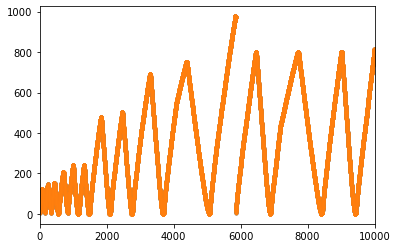

In [9]:

# ds.depth.plot()
# plt.xlim(['Sept 8 2020','Sept 12 2020' ])

# remove nans for the profile breakup
interpd = ds.depth.interpolate()


plt.plot(ds.depth.values, '.')
plt.plot(interpd.values, '.')
plt.xlim([0, 1e4])

# interpd

In [10]:
# find the top and bottom of each profile
apogee, prop = find_peaks(interpd.values,  threshold=None, distance=None, prominence=50)

perogee, prop = find_peaks(-1*interpd.values,  threshold=None, distance=None, prominence=50)

turns = np.sort(np.append(apogee, perogee ))
turns.shape

(703,)

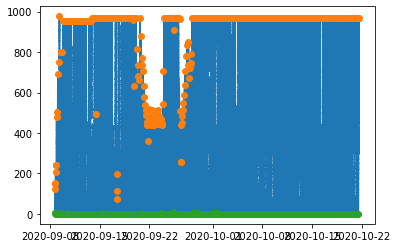

In [13]:
plt.plot(ds.time, ds.depth)
plt.plot(ds.time[apogee], ds.depth[apogee], 'o')
plt.plot(ds.time[perogee], ds.depth[perogee], 'o')



(420000.0, 450000.0)

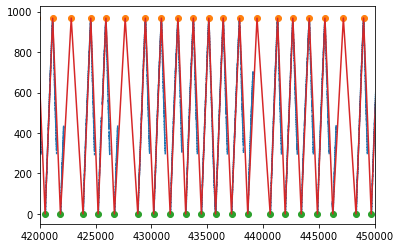

In [22]:
plt.plot( ds.depth)
plt.plot( ds.depth[apogee], 'o')
plt.plot( ds.depth[perogee], 'o')
plt.plot( ds.depth[turns])
# plt.xlim([0, 1e4 ])

plt.xlim([4.2e5, 4.5e5 ])

# GRID!

build a useful dataset for analysis. We will grid some stuff in time and depth, then grid some 1-d stuff to make coordinates and put it all together into an xarray dataset

## start with '2D' gridding

here we are going to bin (grid) stuff that 2 dimentions, like time, and depth

for example: temp, salin, ...

In [42]:
# this is your depth grid, you can set:
zgrd = np.arange(0,1000,5)

# list of variables to grid in 2d:
# you choose
dataz = ['potential_temperature', 'salinity', 'cdom', 'chlorophyll_a', 'beta_700nm']


# this is a dict to hold our gridded stuff
# until we make a dataset later
d2 = {}

# loop on the variables you want to bin
for varz in dataz:    
    values = ds[varz]
    ret = stats.binned_statistic_2d(ds.index.values, ds.depth, values, statistic='mean', bins=[ turns, zgrd ])
    d2[varz] = ret.statistic.T
    
d2.keys()

dict_keys(['potential_temperature', 'salinity', 'cdom', 'chlorophyll_a', 'beta_700nm'])

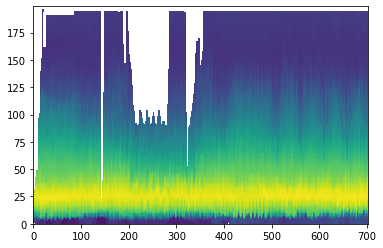

In [41]:
# make a quick plot of the results
plt.pcolormesh(d2['salinity'] )

## next: bin some '1D' stuff
these are things that dont have a depth dimention:
like, time, lat, lon, u, v, ...

In [44]:
# things to bin in the x direction
oneDvars = ['latitude','longitude', 'time']

# dict to hold our 1d bins
d1 = {}

# loop on 1d stuff:
for thing in oneDvars:    
    if thing == 'time':
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].astype(int), statistic = np.nanmean, bins=turns)
        bin_means = pd.to_datetime(bin_means)
    else:
    
        bin_means, bin_edges, binnumber = stats.binned_statistic(ds.index.values,
                    ds[thing].values, statistic = np.nanmean, bins=turns)
    d1[thing] = bin_means
    
d1.keys()

dict_keys(['latitude', 'longitude', 'time'])

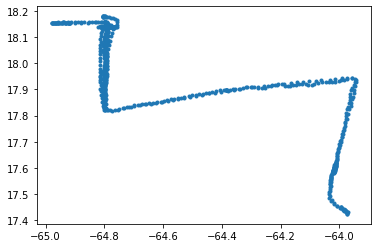

In [45]:
plt.plot( d1['longitude'], d1['latitude'],'.' )